# Unit 5 - Financial Planning


In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [3]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [4]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [5]:
# Fetch current BTC price
btc_data = requests.get(btc_url).json()
btc_price = btc_data['data']['1']['quotes']['USD']['price']

# Fetch current ETH price
eth_data = requests.get(eth_url).json()
eth_price = eth_data['data']['1027']['quotes']['USD']['price']

# Compute current value of my crpto
my_btc_value = my_btc * btc_price
my_eth_value = my_eth * eth_price

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $70544.40
The current value of your 5.3 ETH is $9682.04


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [6]:
# Current amount of shares
my_agg = 200
my_spy = 50

In [7]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Following code used to check if keys are obtained. Used for diagnosis only.
#print(f"Alpaca Key type: {type(alpaca_api_key)}")
#print(f"Alpaca Secret Key type: {type(alpaca_secret_key)}")

# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [8]:
# Format current date as ISO format
today = pd.Timestamp("2021-03-19", tz="America/New_York").isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

# Get current closing prices for SPY and AGG
df_portfolio = alpaca.get_barset(
    tickers,
    timeframe,
    start = today,
    end = today
).df

# Preview DataFrame
df_portfolio.head()

AGG                                     SPY  \
                            open    high     low  close   volume    open   
time                                                                       
2021-03-19 00:00:00-04:00  113.4  113.54  113.33  113.5  4674852  389.88   

                                                             
                              high     low  close    volume  
time                                                         
2021-03-19 00:00:00-04:00  391.569  387.15  389.5  93819590

In [9]:
# Pick AGG and SPY close prices
agg_close_price = float(df_portfolio['AGG']['close'])
spy_close_price = float(df_portfolio['SPY']['close'])

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $113.5
Current SPY closing price: $389.5


In [10]:
# Compute the current value of shares
my_spy_value = spy_close_price * my_spy
my_agg_value = agg_close_price * my_agg

# Print current value of share
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $19475.00
The current value of your 200 AGG shares is $22700.00


### Savings Health Analysis

In [11]:
# Set monthly household income
monthly_income = 12000

# Create savings DataFrame
crypto_total = my_btc_value + my_eth_value
shares_total = my_spy_value + my_agg_value

df_prep = {
    'category' : ['crypto','shares'],
    'amount' : [crypto_total,shares_total]  
}

df_savings = pd.DataFrame(df_prep)
df_savings.set_index('category',inplace=True)

# Display savings DataFrame
display(df_savings)

amount
category          
crypto    80226.44
shares    42175.00

<AxesSubplot:title={'center':'Composition of Personal Savings'}, ylabel='amount'>

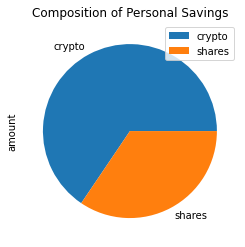

In [12]:
# Plot savings pie chart
df_savings.plot.pie(y="amount", title="Composition of Personal Savings")

In [13]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = float(df_savings.sum())
total_savings = 10

# Validate saving health
if total_savings > emergency_fund:
    print('Congrulations, you have enough money in the fund!')
elif total_savings == emergency_fund:
    print('Congrulations, you are on par with your emergency fund!')
elif total_savings < emergency_fund:
    print(f'You are {-(total_savings-emergency_fund)} away from your goal')

You are 35990 away from your goal


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [14]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2016-03-19', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-03-19', tz='America/New_York').isoformat()

In [15]:
# Get 5 years' worth of historical data for SPY and AGG
df_stock_data = alpaca.get_barset(
    tickers,
    timeframe,
    start = start_date,
    end = end_date,
    limit = 1000 #please note as it's free account, if limit is not specified, it defaults to 100. Further, the maximum from a free acount call is 1000 lines.
).df

# Display sample data
df_stock_data.head()

AGG                                         SPY  \
                             open    high     low   close     volume     open   
time                                                                            
2017-03-29 00:00:00-04:00  108.48  108.62  108.46  108.60  1635068.0      NaN   
2017-03-30 00:00:00-04:00  108.52  108.58  108.38  108.41  1611863.0  235.490   
2017-03-31 00:00:00-04:00  108.44  108.53  108.42  108.52  3151075.0  235.905   
2017-04-03 00:00:00-04:00  108.31  108.68  108.30  108.67  3857775.0  235.800   
2017-04-04 00:00:00-04:00  108.61  108.65  108.52  108.56  1482935.0  235.000   

                                                                
                             high      low   close      volume  
time                                                            
2017-03-29 00:00:00-04:00     NaN      NaN     NaN         NaN  
2017-03-30 00:00:00-04:00  236.52  235.270  236.27  40604487.0  
2017-03-31 00:00:00-04:00  236.51  235.680  235.71  47583793.0  
2017-04-03 00:00:00-04:00  236.03  233.910  235.37  58627715.0  
2017-04-04 00:00:00-04:00  235.58  234.555  235.51  43130784.0

In [16]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_sim_portfolio = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.40,.60],
    num_simulation = 500,
    num_trading_days = 252*30
)

In [17]:
# Printing the simulation input data
MC_sim_portfolio.portfolio_data.head()

AGG                                     \
                             open    high     low   close     volume   
time                                                                   
2017-03-29 00:00:00-04:00  108.48  108.62  108.46  108.60  1635068.0   
2017-03-30 00:00:00-04:00  108.52  108.58  108.38  108.41  1611863.0   
2017-03-31 00:00:00-04:00  108.44  108.53  108.42  108.52  3151075.0   
2017-04-03 00:00:00-04:00  108.31  108.68  108.30  108.67  3857775.0   
2017-04-04 00:00:00-04:00  108.61  108.65  108.52  108.56  1482935.0   

                                            SPY                           \
                          daily_return     open    high      low   close   
time                                                                       
2017-03-29 00:00:00-04:00          NaN      NaN     NaN      NaN     NaN   
2017-03-30 00:00:00-04:00    -0.001750  235.490  236.52  235.270  236.27   
2017-03-31 00:00:00-04:00     0.001015  235.905  236.51  235.680  235.71   
2017-04-03 00:00:00-04:00     0.001382  235.800  236.03  233.910  235.37   
2017-04-04 00:00:00-04:00    -0.001012  235.000  235.58  234.555  235.51   

                                                    
                               volume daily_return  
time                                                
2017-03-29 00:00:00-04:00         NaN          NaN  
2017-03-30 00:00:00-04:00  40604487.0          NaN  
2017-03-31 00:00:00-04:00  47583793.0    -0.002370  
2017-04-03 00:00:00-04:00  58627715.0    -0.001442  
2017-04-04 00:00:00-04:00  43130784.0     0.000595

In [18]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_sim_portfolio.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         1         2         3          4         5          6    \
0      1.000000  1.000000  1.000000  1.000000   1.000000  1.000000   1.000000   
1      0.993108  0.995949  0.989573  1.006841   0.999927  1.008331   0.998366   
2      0.989260  0.989882  0.986846  1.003618   1.002263  1.020586   0.988521   
3      0.990429  0.985368  0.977313  1.003806   1.018327  1.018060   1.001042   
4      0.995888  0.973763  0.976472  0.994245   1.024688  1.028688   0.987792   
...         ...       ...       ...       ...        ...       ...        ...   
7556  15.460506  3.525213  6.266158  9.598704  16.285161  7.392630  56.169067   
7557  15.806097  3.492201  6.412018  9.642512  16.396323  7.348531  56.525776   
7558  15.587187  3.477889  6.447771  9.661136  16.477405  7.411560  58.033066   
7559  15.501911  3.456504  6.472224  9.596673  16.510587  7.418515  58.640663   
7560  15.377812  3.475531  6.477213  9.590313  16.504275  7.410025  59.016767   

            7          8         9    ...        490        491        492  \
0      1.000000   1.000000  1.000000  ...   1.000000   1.000000   1.000000   
1      1.009561   1.003466  0.994224  ...   1.006408   1.003711   1.008651   
2      1.000034   0.995640  0.991217  ...   1.005988   1.006674   1.009700   
3      1.004568   0.985072  0.997728  ...   1.001797   0.999219   1.009303   
4      0.996050   0.978861  1.007982  ...   0.997521   0.990140   1.005428   
...         ...        ...       ...  ...        ...        ...        ...   
7556  16.803419  18.879281  7.739444  ...  34.076519  17.225164  21.900505   
7557  16.822125  18.990612  7.692459  ...  34.129887  17.143443  22.199771   
7558  16.802162  19.107445  7.676160  ...  34.269688  17.062738  22.141156   
7559  16.776451  19.013452  7.708373  ...  34.343793  17.014258  21.778100   
7560  16.866168  19.093164  7.732972  ...  34.493346  17.229125  21.853796   

           493        494       495       496       497       498       499  
0     1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     1.004512   1.002313  0.980833  1.007151  0.991736  1.011192  0.985360  
2     1.003172   1.003720  0.991289  0.992193  0.999538  1.002868  0.992159  
3     0.996925   1.006991  0.983757  1.001613  0.998800  1.012433  0.991060  
4     0.998681   0.995138  0.983545  1.001810  1.000390  1.014074  0.984366  
...        ...        ...       ...       ...       ...       ...       ...  
7556  7.735787  36.765134  9.053100  9.659407  6.375612  7.248101  6.936683  
7557  7.717877  37.148763  9.036740  9.674395  6.379016  7.286815  6.795057  
7558  7.761498  37.037211  9.021180  9.655118  6.388752  7.223245  6.816653  
7559  7.735443  36.819245  8.909085  9.640184  6.426678  7.276818  6.801994  
7560  7.756338  36.767700  9.032674  9.671624  6.431678  7.236659  6.806580  

[7561 rows x 500 columns]

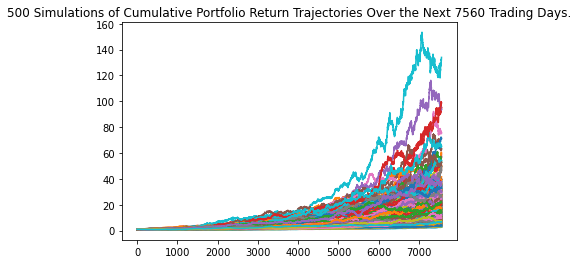

In [19]:
# Plot simulation outcomes
line_plot = MC_sim_portfolio.plot_simulation()

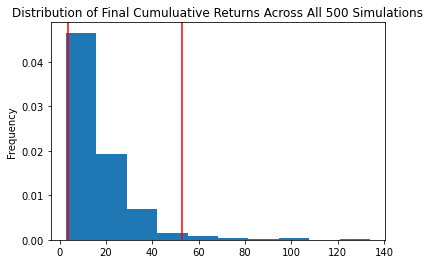

In [20]:
# Plot probability distribution and confidence intervals
dist_plot = MC_sim_portfolio.plot_distribution()

### Retirement Analysis

In [21]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_tbl = MC_sim_portfolio.summarize_cumulative_return()

# Print summary statistics
print(summary_tbl)

count           500.000000
mean             16.811939
std              14.135940
min               2.620879
25%               8.057197
50%              12.910772
75%              20.982180
max             133.950193
95% CI Lower      3.593648
95% CI Upper     52.734904
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the 95% lower and upper confidence intervals based on a `$20,000` initial investment.

In [22]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(summary_tbl[8]*initial_investment,2)
ci_upper = round(summary_tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $71872.95 and $1054698.08


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [23]:
# Set initial investment
initial_investment_50more = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower_50more = round(summary_tbl[8]*initial_investment_50more,2)
ci_upper_50more = round(summary_tbl[9]*initial_investment_50more,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_50more} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower_50more} and ${ci_upper_50more}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $107809.43 and $1582047.12


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [24]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_simulation_5years = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.40,.60],
    num_simulation = 500,
    num_trading_days = 252*5
)
MC_simulation_5years.portfolio_data.head()

AGG                                     \
                             open    high     low   close     volume   
time                                                                   
2017-03-29 00:00:00-04:00  108.48  108.62  108.46  108.60  1635068.0   
2017-03-30 00:00:00-04:00  108.52  108.58  108.38  108.41  1611863.0   
2017-03-31 00:00:00-04:00  108.44  108.53  108.42  108.52  3151075.0   
2017-04-03 00:00:00-04:00  108.31  108.68  108.30  108.67  3857775.0   
2017-04-04 00:00:00-04:00  108.61  108.65  108.52  108.56  1482935.0   

                                            SPY                           \
                          daily_return     open    high      low   close   
time                                                                       
2017-03-29 00:00:00-04:00          NaN      NaN     NaN      NaN     NaN   
2017-03-30 00:00:00-04:00    -0.001750  235.490  236.52  235.270  236.27   
2017-03-31 00:00:00-04:00     0.001015  235.905  236.51  235.680  235.71   
2017-04-03 00:00:00-04:00     0.001382  235.800  236.03  233.910  235.37   
2017-04-04 00:00:00-04:00    -0.001012  235.000  235.58  234.555  235.51   

                                                    
                               volume daily_return  
time                                                
2017-03-29 00:00:00-04:00         NaN          NaN  
2017-03-30 00:00:00-04:00  40604487.0          NaN  
2017-03-31 00:00:00-04:00  47583793.0    -0.002370  
2017-04-03 00:00:00-04:00  58627715.0    -0.001442  
2017-04-04 00:00:00-04:00  43130784.0     0.000595

In [25]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_simulation_5years.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         1         2         3         4         5         6    \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     0.995106  1.006452  1.002508  1.011348  1.002218  0.992071  1.000441   
2     1.001148  1.002755  1.012129  1.013476  1.006639  0.998666  1.003441   
3     0.988866  1.007939  1.014493  1.011378  1.000648  0.991699  1.006196   
4     0.978905  1.010008  1.020456  1.026227  1.002467  0.982845  1.013765   
...        ...       ...       ...       ...       ...       ...       ...   
1256  2.243304  1.155455  1.416151  1.194914  1.672433  1.413075  1.115364   
1257  2.247388  1.151465  1.392297  1.179989  1.674269  1.399629  1.118777   
1258  2.235561  1.149673  1.400966  1.181077  1.690948  1.400010  1.125509   
1259  2.213807  1.155138  1.414962  1.161096  1.684778  1.399414  1.150403   
1260  2.214635  1.146748  1.418444  1.166219  1.692531  1.400632  1.158674   

           7         8         9    ...       490       491       492  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     1.009287  1.016123  0.993998  ...  1.012986  1.013594  0.999919   
2     1.008734  1.003779  0.994837  ...  1.001877  1.022327  1.007987   
3     1.003853  1.012205  0.990255  ...  0.992751  1.027220  1.014893   
4     1.001443  1.031544  1.004881  ...  1.010267  1.029635  1.003075   
...        ...       ...       ...  ...       ...       ...       ...   
1256  1.968292  1.051375  1.534808  ...  1.520839  2.733126  0.989426   
1257  1.953327  1.039840  1.520331  ...  1.508316  2.717092  0.993081   
1258  1.967857  1.038135  1.527632  ...  1.513143  2.724893  0.993842   
1259  1.943655  1.030121  1.544367  ...  1.518632  2.756559  0.994340   
1260  1.955191  1.028953  1.539849  ...  1.527742  2.769316  1.007186   

           493       494       495       496       497       498       499  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     1.007954  1.003614  1.008118  0.993390  1.008405  1.014943  1.000667  
2     1.012791  1.007942  1.010705  1.000054  1.001551  1.017788  1.005212  
3     1.003681  1.015780  1.015176  1.011666  0.998926  1.025169  1.002401  
4     1.003312  1.006638  1.012366  1.016717  1.011980  1.028630  0.989584  
...        ...       ...       ...       ...       ...       ...       ...  
1256  1.762908  1.802228  1.005852  2.899195  1.431751  1.250454  1.906918  
1257  1.777854  1.797272  0.996031  2.889751  1.431444  1.251551  1.912101  
1258  1.786435  1.798162  0.994927  2.890028  1.456712  1.245053  1.894571  
1259  1.803042  1.808681  0.982809  2.884081  1.457382  1.219308  1.920243  
1260  1.819641  1.828580  0.987584  2.894876  1.440593  1.226674  1.920387  

[1261 rows x 500 columns]

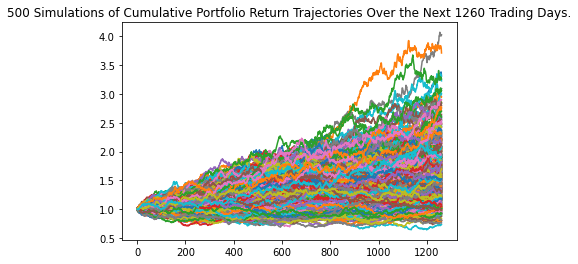

In [26]:
# Plot simulation outcomes
line_plot_5years = MC_simulation_5years.plot_simulation()

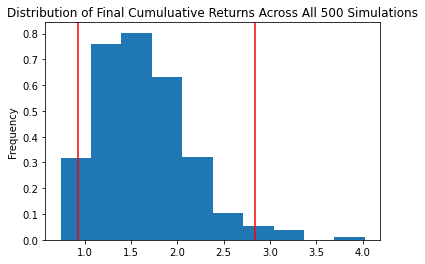

In [27]:
# Plot probability distribution and confidence intervals
dist_plot_5years = MC_simulation_5years.plot_distribution()

In [28]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_5years = MC_simulation_5years.summarize_cumulative_return()

# Print summary statistics
print(summary_5years)

count           500.000000
mean              1.632673
std               0.492998
min               0.738060
25%               1.262238
50%               1.568839
75%               1.901867
max               4.024113
95% CI Lower      0.921894
95% CI Upper      2.839315
Name: 1260, dtype: float64


In [29]:
# Set initial investment
initial_investment_cfo = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round(summary_5years[8]*initial_investment_cfo,2)
ci_upper_five = round(summary_5years[9]*initial_investment_cfo,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_cfo} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 5 years will end within in the range of $18437.88 and $56786.29


### Ten Years Retirement Option

In [30]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_simulation_10years = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.40,.60],
    num_simulation = 500,
    num_trading_days = 252*10
)
MC_simulation_10years.portfolio_data.head()

AGG                                     \
                             open    high     low   close     volume   
time                                                                   
2017-03-29 00:00:00-04:00  108.48  108.62  108.46  108.60  1635068.0   
2017-03-30 00:00:00-04:00  108.52  108.58  108.38  108.41  1611863.0   
2017-03-31 00:00:00-04:00  108.44  108.53  108.42  108.52  3151075.0   
2017-04-03 00:00:00-04:00  108.31  108.68  108.30  108.67  3857775.0   
2017-04-04 00:00:00-04:00  108.61  108.65  108.52  108.56  1482935.0   

                                            SPY                           \
                          daily_return     open    high      low   close   
time                                                                       
2017-03-29 00:00:00-04:00          NaN      NaN     NaN      NaN     NaN   
2017-03-30 00:00:00-04:00    -0.001750  235.490  236.52  235.270  236.27   
2017-03-31 00:00:00-04:00     0.001015  235.905  236.51  235.680  235.71   
2017-04-03 00:00:00-04:00     0.001382  235.800  236.03  233.910  235.37   
2017-04-04 00:00:00-04:00    -0.001012  235.000  235.58  234.555  235.51   

                                                    
                               volume daily_return  
time                                                
2017-03-29 00:00:00-04:00         NaN          NaN  
2017-03-30 00:00:00-04:00  40604487.0          NaN  
2017-03-31 00:00:00-04:00  47583793.0    -0.002370  
2017-04-03 00:00:00-04:00  58627715.0    -0.001442  
2017-04-04 00:00:00-04:00  43130784.0     0.000595

In [31]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_simulation_10years.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         1         2         3         4         5         6    \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     1.005544  1.002727  0.993345  1.005703  0.997286  1.005866  1.011098   
2     1.008933  0.997744  0.995048  1.005671  0.986154  1.009098  1.007722   
3     1.008491  1.007091  1.004479  1.002296  0.994378  1.025195  1.007760   
4     1.008986  1.011656  1.001092  0.994551  1.002227  1.026718  1.026301   
...        ...       ...       ...       ...       ...       ...       ...   
2516  1.619576  1.887261  2.679092  2.840518  2.406890  2.185287  2.428515   
2517  1.625239  1.859324  2.689479  2.873782  2.390862  2.177246  2.459856   
2518  1.628999  1.853021  2.696772  2.898904  2.413566  2.172830  2.432639   
2519  1.609584  1.861957  2.713103  2.870212  2.430758  2.169568  2.432114   
2520  1.610989  1.855570  2.726518  2.885326  2.422131  2.135437  2.426863   

           7         8         9    ...       490       491       492  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     1.012265  0.991743  1.009426  ...  0.994596  0.987665  1.010746   
2     1.004563  0.986118  1.011171  ...  0.989826  0.989979  1.005818   
3     1.009496  0.988206  1.012529  ...  0.987160  0.991933  1.001615   
4     1.012757  0.979069  1.005880  ...  0.992420  0.993534  0.995819   
...        ...       ...       ...  ...       ...       ...       ...   
2516  1.633350  1.137533  2.053384  ...  1.445326  2.068711  1.820234   
2517  1.636763  1.118917  2.041836  ...  1.452321  2.080616  1.839941   
2518  1.642660  1.127443  2.032998  ...  1.430931  2.071388  1.854997   
2519  1.657312  1.147508  2.061176  ...  1.442310  2.067510  1.848117   
2520  1.651512  1.154851  2.090892  ...  1.434934  2.067595  1.846910   

           493       494       495       496       497       498       499  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     0.997735  0.998165  0.985245  0.992896  1.008629  1.001107  1.005208  
2     0.994685  0.998598  0.968583  0.982165  1.008280  0.996795  1.022723  
3     0.994427  0.982528  0.957604  0.983594  1.001642  1.008615  1.027586  
4     0.994015  0.979260  0.944479  0.983526  1.005637  1.008650  1.016569  
...        ...       ...       ...       ...       ...       ...       ...  
2516  4.080811  3.294691  2.005780  3.489195  2.289412  3.160185  2.204125  
2517  4.097687  3.285171  2.018411  3.492072  2.284958  3.149029  2.200244  
2518  4.142445  3.316217  2.029249  3.489549  2.297240  3.149473  2.188016  
2519  4.119699  3.303567  2.041231  3.491328  2.285604  3.165607  2.175814  
2520  4.093907  3.282261  2.056380  3.487665  2.287697  3.155253  2.178554  

[2521 rows x 500 columns]

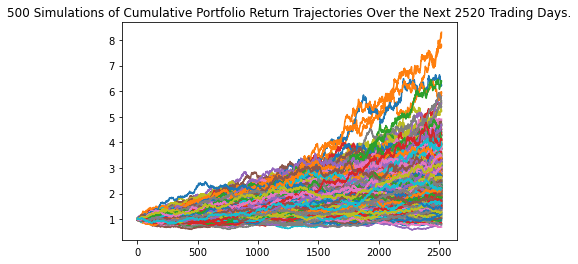

In [32]:
# Plot simulation outcomes
line_plot_10years = MC_simulation_10years.plot_simulation()

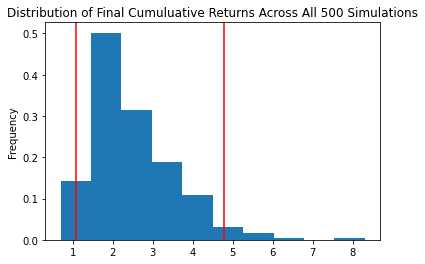

In [33]:
# Plot probability distribution and confidence intervals
dist_plot_10years = MC_simulation_10years.plot_distribution()

In [34]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_10years = MC_simulation_10years.summarize_cumulative_return()

# Print summary statistics
print(summary_10years)

count           500.000000
mean              2.488047
std               1.047744
min               0.690853
25%               1.721058
50%               2.230751
75%               3.056302
max               8.305668
95% CI Lower      1.069680
95% CI Upper      4.782740
Name: 2520, dtype: float64


In [35]:
# Set initial investment
#no code required as using initial_investment_cfo to be consistent with investment amount for comparison purposes

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten = round(summary_10years[8]*initial_investment_cfo,2)
ci_upper_ten = round(summary_10years[9]*initial_investment_cfo,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_cfo} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 10 years will end within in the range of $21393.6 and $95654.79
